In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy import stats
import statsmodels

In [2]:
plt.style.use('seaborn-v0_8-paper')
pt = 1./72.27
fig_width = 239 * pt
aspect_ratio = (1 + 8 ** 0.5) / 2
plt.rcParams["figure.figsize"] = (fig_width, fig_width/aspect_ratio)
plt.rcParams["savefig.bbox"] = "tight"
sns.set_theme(style='whitegrid', context='paper', rc={'axes.facecolor': 'white', 'figure.figsize': (fig_width, fig_width/aspect_ratio)})
# sns.set_theme(style='whitegrid', context='paper', rc={'savefig.transparent': True, 'figure.figsize': (fig_width, fig_width/aspect_ratio), 'axes.labelsize': 14})

colors = ["#00a1de", "#009b3a", "#c60c30", "#f9461c", "#532A92"]

In [3]:
machine_list = {
    "machine1": { 'id': 'machine1', 'text': 'Machine 1', 'max_power': 20},
    "machine2": { 'id': 'machine2', 'text': 'Machine 2', 'max_power': 40},
    "machine3": { 'id': 'machine3', 'text': 'Machine 3', 'max_power': 40},
    "machine4": { 'id': 'machine4', 'text': 'Machine 4', 'max_power': 30}
}

with open("static/sample_jobs.json") as fp:
    jobs = json.load(fp)
    
def energy_cost(machine, job):
    return ((machine_list[machine]['max_power'] * job["resources"][machine]["runtime"]) + job["resources"][machine]["energy"]) / 2

In [4]:
df = pd.read_csv("game_responses.csv", index_col=0)

In [5]:
df

,_id,jobs_completed,timeLeft,total_allocation,allocation,total_energy,total_runtime,scheduling_decisions,job_idx,userID,plays,visits,group,startTime,gameTime,version
0,66be38d1217dee6c11eced47,11,4,200,77.000000,2123.385714,123,"{'7': {'machine1': ['10', 1], 'machine2': ['13...",16,1on9b7a,2,2,2,1723742065812,329560,1
1,66be39933bebf2876408dc66,9,22,3000,0.157143,2159.685714,118,"{'30': {'machine1': ['9', 0.8888888888888888],...",14,1on9b7a,3,3,2,1723742419420,190058,3
2,66be3a39217dee6c11eced48,16,0,200,29.000000,3078.900000,171,"{'1': {'machine1': ['19', 1]}, '2': {'machine2...",20,1on9b7a,4,4,2,1723742626191,151298,1
3,66bf707b09f21551ff542cfd,12,12,200,8.000000,3518.994242,192,"{'13': {'machine1': ['8', 0.05], 'machine2': [...",17,19abi9c,2,2,0,1723822133887,63355,1
4,66bf70a2ddc4307faabac4a7,9,11,200,4.000000,3954.324242,196,"{'20': {'machine1': ['7', 1], 'machine2': ['8'...",14,19abi9c,3,3,0,1723822209789,24594,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,66dad6b23bebf2876408dcaf,11,7,200,2.000000,3515.735584,198,"{'10': {'machine1': ['10', 0.3333333333333333]...",16,1l3my9v,2,2,0,1725616719133,1086099,1
203,66dad9003bebf2876408dcb0,19,4,200,9.000000,3533.000000,191,"{'4': {}, '10': {'machine2': ['15', 1]}, '11':...",20,1l3my9v,3,3,0,1725617848162,581944,2
204,66df03dd217dee6c11eced9b,16,2,3000,16.350000,2127.300000,125,"{'3': {'machine1': ['19', 1]}, '7': {'machine1...",20,19vqkwl,2,2,5,1725891059130,487805,3
205,66df0540217dee6c11eced9c,19,0,200,14.000000,3511.400000,186,"{'1': {'machine3': ['9', 1]}, '6': {'machine3'...",20,19vqkwl,3,3,5,1725891560985,343574,2


In [6]:
df.userID.nunique()

90

Text(0.5, 0, 'Real Time Taken (Minutes)')

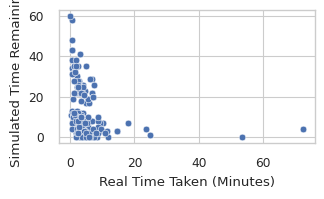

In [7]:
df["gameTimeMin"] = df["gameTime"] /(1e3 * 60)
fig, ax = plt.subplots(1,1)
sns.scatterplot(data=df, x="gameTimeMin", y="timeLeft", ax=ax)
ax.set_ylabel("Simulated Time Remaining")
ax.set_xlabel("Real Time Taken (Minutes)")

In [8]:
df = df[df["gameTimeMin"] > 1]
df["energy_per_job"] = df["total_energy"] / df["jobs_completed"]
df["energy_per_time"] = df["total_energy"] / df["total_runtime"]
df.shape

/tmp/ipykernel_3101/2225852331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["energy_per_job"] = df["total_energy"] / df["jobs_completed"]
/tmp/ipykernel_3101/2225852331.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["energy_per_time"] = df["total_energy"] / df["total_runtime"]


(192, 19)

/tmp/ipykernel_3101/1079387758.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="version", y="total_energy", order=["1","2","3"], ax=ax, palette=colors)
/tmp/ipykernel_3101/1079387758.py:2: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.violinplot(data=df, x="version", y="total_energy", order=["1","2","3"], ax=ax, palette=colors)


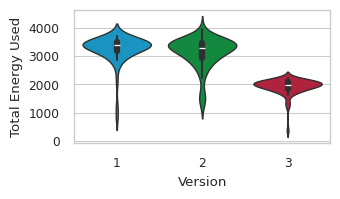

In [9]:
fig,ax = plt.subplots(1,1)
sns.violinplot(data=df, x="version", y="total_energy", order=["1","2","3"], ax=ax, palette=colors)
ax.set_xlabel("Version")
ax.set_ylabel("Total Energy Used")
plt.savefig("figures/game_total_energy.pdf")
# plt.savefig("figures/game_total_energy_talk.png")

In [10]:
display(df[df["version"] == 1]["total_energy"].describe())
display(df[df["version"] == 2]["total_energy"].describe())
display(df[df["version"] == 3]["total_energy"].describe())
display(stats.ttest_ind(df[df["version"] == 1]["total_energy"], df[df["version"] == 2]["total_energy"]))
display(stats.ttest_ind(df[df["version"] == 1]["total_energy"], df[df["version"] == 3]["total_energy"]))
display(stats.ttest_ind(df[df["version"] == 2]["total_energy"], df[df["version"] == 3]["total_energy"]))

count      63.000000
mean     3262.544559
std       497.134247
min       809.900000
25%      3206.602500
50%      3393.800535
75%      3497.816815
max      3736.712054
Name: total_energy, dtype: float64

count      62.000000
mean     3142.400934
std       546.484256
min      1268.400000
25%      2960.500000
50%      3293.653351
75%      3477.772917
max      3959.892091
Name: total_energy, dtype: float64

count      67.000000
mean     1928.516872
std       277.419640
min       370.100000
25%      1851.169559
50%      1981.483333
75%      2093.775566
max      2215.990909
Name: total_energy, dtype: float64

TtestResult(statistic=np.float64(1.2861206282093651), pvalue=np.float64(0.2008167296086517), df=np.float64(123.0))

TtestResult(statistic=np.float64(19.039969314094815), pvalue=np.float64(3.727013129333428e-39), df=np.float64(128.0))

TtestResult(statistic=np.float64(16.083077989336413), pvalue=np.float64(2.0018894585596637e-32), df=np.float64(127.0))

/tmp/ipykernel_3101/1967740162.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="version", y="jobs_completed", order=[1,2,3], ax=ax, palette=colors)
/tmp/ipykernel_3101/1967740162.py:2: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.violinplot(data=df, x="version", y="jobs_completed", order=[1,2,3], ax=ax, palette=colors)


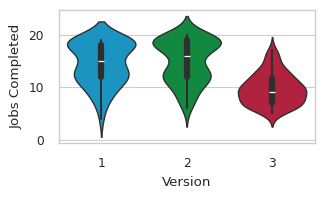

In [11]:
fig,ax = plt.subplots(1,1)
sns.violinplot(data=df, x="version", y="jobs_completed", order=[1,2,3], ax=ax, palette=colors)
ax.set_xlabel("Version")
ax.set_ylabel("Jobs Completed")
plt.savefig("figures/game_jobs_completed.pdf")
# plt.savefig("figures/game_jobs_completed_talk.png")

In [12]:
display(df[df["version"] == 1]["jobs_completed"].describe())
display(df[df["version"] == 2]["jobs_completed"].describe())
display(df[df["version"] == 3]["jobs_completed"].describe())
display(stats.ttest_ind(df[df["version"] == 1]["jobs_completed"], df[df["version"] == 2]["jobs_completed"]))
display(stats.ttest_ind(df[df["version"] == 1]["jobs_completed"], df[df["version"] == 3]["jobs_completed"]))
display(stats.ttest_ind(df[df["version"] == 2]["jobs_completed"], df[df["version"] == 3]["jobs_completed"]))

count    63.000000
mean     14.476190
std       3.995389
min       4.000000
25%      12.000000
50%      15.000000
75%      18.000000
max      19.000000
Name: jobs_completed, dtype: float64

count    62.000000
mean     14.887097
std       4.020867
min       6.000000
25%      12.000000
50%      16.000000
75%      19.000000
max      20.000000
Name: jobs_completed, dtype: float64

count    67.000000
mean      9.686567
std       2.919158
min       5.000000
25%       7.000000
50%       9.000000
75%      11.500000
max      17.000000
Name: jobs_completed, dtype: float64

TtestResult(statistic=np.float64(-0.5730880496252491), pvalue=np.float64(0.5676313092764956), df=np.float64(123.0))

TtestResult(statistic=np.float64(7.8375078686067505), pvalue=np.float64(1.5507776426703238e-12), df=np.float64(128.0))

TtestResult(statistic=np.float64(8.451121179172661), pvalue=np.float64(5.753422091040446e-14), df=np.float64(127.0))

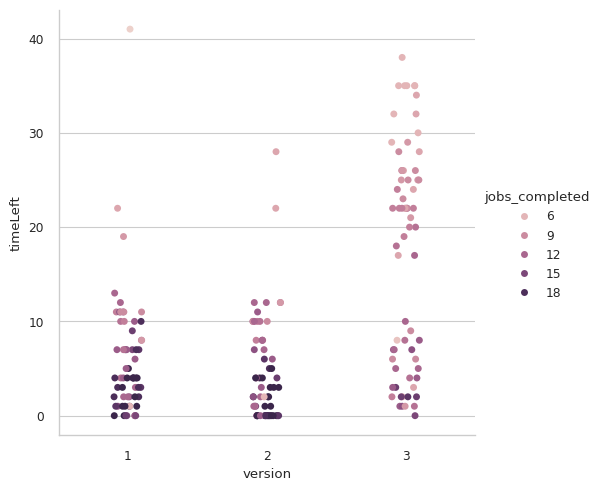

In [13]:
sns.catplot(data=df, x="version", y="timeLeft", order=["1","2","3"], hue="jobs_completed")

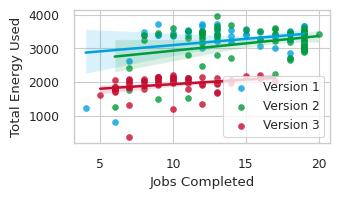

In [14]:
fig,ax = plt.subplots(1,1)
# sns.scatterplot(data=df, x="jobs_completed", y="energy_per_job", hue="version", ax=ax)
sns.regplot(data=df[df["version"] == 1], x="jobs_completed", y="total_energy", color=colors[0], label="Version 1", ax=ax)
sns.regplot(data=df[df["version"] == 2], x="jobs_completed", y="total_energy", color=colors[1], label="Version 2", ax=ax)
sns.regplot(data=df[df["version"] == 3], x="jobs_completed", y="total_energy", color=colors[2], label="Version 3",  ax=ax)
plt.legend(loc="lower right")
ax.set_xlabel("Jobs Completed")
ax.set_ylabel("Total Energy Used")
plt.savefig("figures/energy_used_by_jobs_completed.pdf")
# plt.savefig("figures/energy_used_by_jobs_completed_talk.png")

In [15]:
def parse_schedule(user):
    job_assignments = {}
    for timestep, decisions in json.loads(user.scheduling_decisions.replace("'", "\"")).items():
        for machine, job_prop in decisions.items():
            if job_prop[1] == 1:
                job_assignments[int(job_prop[0])] = machine
    
    job_energy = {i: np.nan for  i in range(len(jobs))}
    for job_idx, machine in job_assignments.items():
        job_energy[job_idx] = jobs[job_idx]["resources"][machine]["energy"]
    job_energy["version"] = user.version
    job_energy["job_idx"] = user.job_idx
            
    return pd.Series(job_energy)

energy_per_job = df.apply(parse_schedule, axis=1)
energy_per_job

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,version,job_idx
0,123.4,299.8,71.3,147.0,96.7,80.0,NaN,NaN,NaN,399.7,...,355.4,78.8,NaN,NaN,NaN,NaN,NaN,NaN,1.0,16.0
1,191.6,299.8,71.3,147.0,96.7,455.8,96.0,419.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,14.0
2,191.6,425.4,311.7,147.0,15.8,80.0,441.8,256.5,292.5,399.7,...,NaN,17.6,129.1,NaN,NaN,10.5,NaN,8.5,1.0,20.0
3,43.1,62.2,451.9,646.9,67.6,393.3,96.0,419.9,NaN,399.7,...,410.1,NaN,129.1,NaN,NaN,NaN,NaN,NaN,1.0,17.0
5,123.4,299.8,71.3,NaN,15.8,NaN,NaN,256.5,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,191.6,425.4,71.3,147.0,15.8,393.3,455.5,419.9,292.5,84.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,16.0
203,43.1,425.4,311.7,646.9,15.8,80.0,96.0,419.9,NaN,399.7,...,68.5,78.8,129.1,249.2,42.2,48.6,66.9,60.0,2.0,20.0
204,123.4,299.8,311.7,332.3,15.8,80.0,NaN,419.9,NaN,84.5,...,68.5,78.8,129.1,49.4,42.2,48.6,NaN,8.5,3.0,20.0
205,43.1,425.4,71.3,34.0,281.2,393.3,96.0,419.9,NaN,602.1,...,68.5,78.8,129.1,249.2,42.2,197.5,20.1,8.5,2.0,20.0


In [16]:
melted = pd.melt(energy_per_job, id_vars=["version", "job_idx"], var_name="job_id", value_name="energy")
melted["run"] = ~melted["energy"].isna()
melted["could_run"] = melted["job_id"] <= melted["job_idx"]
melted

,version,job_idx,job_id,energy,run,could_run
0,1.0,16.0,0,123.4,True,True
1,3.0,14.0,0,191.6,True,True
2,1.0,20.0,0,191.6,True,True
3,1.0,17.0,0,43.1,True,True
4,3.0,10.0,0,123.4,True,True
...,...,...,...,...,...,...
3835,1.0,16.0,19,NaN,False,False
3836,2.0,20.0,19,60.0,True,True
3837,3.0,20.0,19,8.5,True,True
3838,2.0,20.0,19,8.5,True,True


Text(0, 0.5, 'Proportion Ran Job')

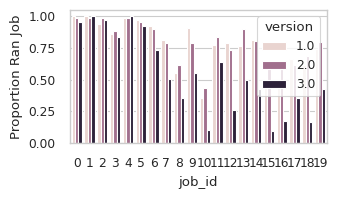

In [17]:
grouped = melted[melted["could_run"] == True].groupby(["job_id", "version"])["run"].value_counts(normalize=True).unstack().reset_index()
fig, ax = plt.subplots(1,1)
sns.barplot(data=grouped, x="job_id", y=True, hue="version", ax=ax)
ax.set_ylabel("Proportion Ran Job")
# sns.countplot(data=melted, x="job_id", hue="version")

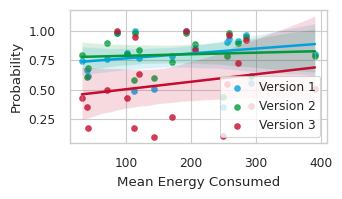

In [18]:
grouped = melted[melted["could_run"] == True].groupby(["job_id", "version"])[["run", "energy"]].agg({"run": ["sum", len], "energy": "mean"}).reset_index()
grouped.columns = ["job_id", "version", "run", "could_run", "energy"]
grouped["prop_ran"] = grouped["run"] / grouped["could_run"]
grouped["energy"] = grouped.groupby(["job_id"])["energy"].transform("mean")

fig, ax = plt.subplots(1,1)
sns.regplot(data=grouped[grouped["version"] == 1], x="energy", y="prop_ran", color=colors[0], label="Version 1", robust=True, ax=ax)
sns.regplot(data=grouped[grouped["version"] == 2], x="energy", y="prop_ran", color=colors[1], label="Version 2", robust=True, ax=ax)
sns.regplot(data=grouped[grouped["version"] == 3], x="energy", y="prop_ran", color=colors[2], label="Version 3", robust=True, ax=ax)
# sns.scatterplot(grouped, x="energy", y="prop_ran", hue="version", ax=ax)
# ax.get_legend().remove()
plt.legend(loc="lower right")
ax.set_ylabel("Probability")
ax.set_xlabel("Mean Energy Consumed")
plt.savefig("figures/game_job_probability_by_energy.pdf")
# plt.savefig("figures/game_job_probability_by_energy_talk.png")

/tmp/ipykernel_3101/702893150.py:3: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  fig = sns.barplot(melted, x="job_id", y="energy", hue="version_", hue_order=["Version 1", "Version 2", "Version 3"], palette=colors, errorbar=None)


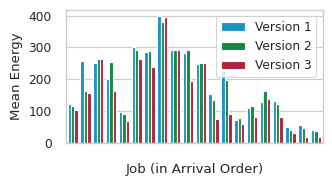

In [19]:
fig, ax = plt.subplots(1,1)
melted["version_"]  = melted["version"].map({1: "Version 1", 2: "Version 2", 3: "Version 3"})
fig = sns.barplot(melted, x="job_id", y="energy", hue="version_", hue_order=["Version 1", "Version 2", "Version 3"], palette=colors, errorbar=None)
ax.get_legend().set_title(None)
ax.set_xticklabels([])
ax.set_xlabel("Job (in Arrival Order)")
ax.set_ylabel("Mean Energy")
plt.savefig("figures/game_energy_by_job.pdf")
plt.savefig("figures/game_energy_by_job_talk.png")

# 